In [27]:
import numpy as np
import pandas as pd
import glob
import os
import re

import sugartensor as tf
from train import *
import utils

import tensorflow as tfw
import librosa
import pydub
from scipy.io.wavfile import read, write
from pydub import AudioSegment

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from scipy import signal

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

## Предобработка данных из датасета VCTK 

In [2]:
audio_indexes = [225+x for x in range(152)]

In [3]:
audio_adress=[]
text_adress=[]
for i in range(152):
    audio_adress.append(sorted(glob.glob("/workspace/code/data/VCTK-Corpus/wav48/p"+str(audio_indexes[i])+"/*.wav")))
    text_adress.append(sorted(glob.glob("/workspace/code/data/VCTK-Corpus/txt/p"+str(audio_indexes[i])+"/*.txt")))

In [4]:
IPython.display.Audio(audio_adress[1][5])

In [5]:
print(open(text_adress[1][5]).read())

When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. 



Объявляем гиперпараметры

In [6]:
tf.sg_verbosity(10)
batch_size = 1     
voca_size = data.voca_size
x = tf.placeholder(dtype=tf.sg_floatx, shape=(batch_size, None, 20))

seq_len = tf.not_equal(x.sg_sum(axis=2), 0.).sg_int().sg_sum(axis=1)
logit = get_logit(x, voca_size=voca_size)
decoded, _ = tf.nn.ctc_beam_search_decoder(logit.sg_transpose(perm=[1, 0, 2]), seq_len, merge_repeated=False)

y = tf.sparse_to_dense(decoded[0].indices, decoded[0].dense_shape, decoded[0].values) + 1


Функция для распознавания. Сперва картинка представляется в виде mfcc, а затем передается в уже предобученный распознаватель

In [7]:
def recognize(filename):
    wav, _ = librosa.load(filename, mono=True, sr=16000)
    # get mfcc feature
    mfcc = np.transpose(np.expand_dims(librosa.feature.mfcc(wav, 16000), axis=0), [0, 2, 1])
    with tf.Session() as sess:
        tf.sg_init(sess)
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint('/workspace/code/code'))
        #print('recognized text: ')
        s=data.print_index(sess.run(y, feed_dict={x: mfcc}))
        return s

Посмотрим на примере одной аудиозаписи, что получится

In [8]:
s=recognize(audio_adress[1][5])

INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


In [9]:
s

'when the sun lech strikes raindrops in the ar they act as a prisom and form a rainbow'

In [10]:
print(open(text_adress[1][5],'r').read())

When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow. 



Для того, чтобы понять, хорошо ли работает алгоритм, используем **word_error_rate**: $WER$ характеризует количество преобразований, которые необходимо сделать, чтобы превратить одну строку в другую
$\frac{S+D+I}{N}$, здесь $S$ $-$ замены, $D$ $-$ удаления, $I$ $-$ вставки, $N$ $-$ число слов в распознаваемой строке.
    

In [11]:
def word_error_rate(r, h):
    """
    Подсчет при помощи расстояния Левинштейна
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]


Теперь запустим алгоритм распознавания. Для каждой распознанной фразы будем строить WER и запоминать

In [12]:
recognized_text=[]
word_error_rates=[]
# первые 10 аудиозаписей первых 10 людей
for i in tqdm(range(10)):
    try:
        for j in range(10):
            j += 1
            i += 1
            tmp=recognize(audio_adress[j][i])
            recognized_text.append(tmp)
            print(tmp)
            print('original:')
            o=open(text_adress[j][i],'r').read().lower()
            original=re.sub(r'[^\w\s]','',o)
            print(original)
            if len(original)==0:
                continue
            wer=word_error_rate(tmp,original)
            word_error_rates.append(wer)
            print('current wer: {}%'.format(wer))
            print('\n========================================================\n')
    except IndexError:
        print('no such record')
        continue


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
ask ha to bring these things with har from the stoe
original:
ask her to bring these things with her from the store  

current wer: 7%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
six spoons of fresh snow peas five thick slups of blue chees and maybe a snock for her brother bob
original:

INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
we also need a small plastic snake and a big toy frog for te kids
original:
we also need a small plastic snake and a big toy frog for the kids

current wer: 2%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
she can scoipe these things into tre red bags a mowlgoe meet he wenesday o the train station
original:
she can scoop these things into three red bags and we will go meet her wednesday at the train station 

current wer: 19%


INFO:tensorflow:Restoring parameters from

 10%|█         | 1/10 [00:21<03:16, 21.87s/it]

people liok but no one ever finds it
original:
people look but no one ever finds it 

current wer: 3%


no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
six spoons of fresh now peas five thick slabs of blue cheese and mayboua snack fohr brother bob
original:

INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
we also need e small pastic snake and the big toy frog for the kids
original:
we also need a small plastic snake and a big toy frog for the kids  

current wer: 8%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
she can scoip these things into threh rad bags and we will go meet t howr wednesday at the train station
original:
she can scoop these things into three red bags and we will go meet her wednesday at the train station

current wer: 8%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
when the sunnight strikes raindrops in the ar th

 20%|██        | 2/10 [00:52<03:31, 26.42s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
we al so need a small plastic snake and a big toy frog fo the kids
original:
we also need a small plastic snake and a big toy frog for the kids  

current wer: 5%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
shel can scoop these things into three red bags and we will go meet her wednesday at the train station
original:
she can scoop these things into three red bags and we will go meet her wednesday at the train station 

current wer: 3%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
when the sunnight strikes raindrops in the air they act as a prism and form a rainbow
original:
when the sunlight strikes raindrops in the air they act as a prism and form a rainbow

current wer: 2%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
the rainbow is a division of white light into many beaseifur

 30%|███       | 3/10 [01:27<03:23, 29.03s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
she can scoop these things into three red bags and we will go meet her wednesday at the train station
original:
she can scoop these things into three red bags and we will go meet her wednesday at the train station 

current wer: 2%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
when the sunlight strike rain drops i dear they act a a prisom and form a rainbow
original:
when the sunlight strikes raindrops in the air they act as a prism and form a rainbow 

current wer: 11%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
the ran bow is a devigion of white light into many meaugiful colors
original:
the rainbow is a division of white light into many beautiful colors

current wer: 7%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
these take the shape of a long round arch wirh this path high a

 40%|████      | 4/10 [02:03<03:05, 30.91s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
when the sun lech strikes raindrops in the ar they act as a prisom and form a rainbow
original:
when the sunlight strikes raindrops in the air they act as a prism and form a rainbow 

current wer: 8%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
these take the shape of a long round arch with its path high above and it two ens a partly beyond the horrizon
original:
these take the shape of a long round arch with its path high above and its two ends apparently beyond the horizon 

current wer: 8%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
these take the shape of a long round arch with its patt high above and its two ends appaently beyond the horizson
original:
these take the shape of a long round arch with its path high above and its two ends apparently beyond the horizon

current wer: 4%


INFO:tensorflow:Restoring pa

 50%|█████     | 5/10 [02:38<02:38, 31.64s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
the rainbow is a division of white light into many beautiful colors
original:
the rainbow is a division of white light into many beautiful colors 

current wer: 2%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
thare is a condunt ter legent a boiling pott of golt at oneend
original:
there is  according to legend a boiling pot of gold at one end 

current wer: 14%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
thare is according to legend a boiling pot of gold ut one ent
original:
there is  according to legend a boiling pot of gold at one end

current wer: 5%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
people look but no one everfinds it
original:
people look but no one ever finds it 

current wer: 3%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


 60%|██████    | 6/10 [03:10<02:06, 31.73s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
these take the shape of a long round aurch wit its path high above and is two ends appareny beyond the horizon
original:
these take the shape of a long round arch with its path high above and its two ends apparently beyond the horizon 

current wer: 7%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
a pul look but no one ever finds it
original:
people look but no one ever finds it 

current wer: 7%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
people look but no one ever findt it
original:
people look but no one ever finds it

current wer: 2%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


 70%|███████   | 7/10 [03:38<01:33, 31.16s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
there is according to aelegend a boiling pot of gold at one end
original:
there is  according to legend a boiling pot of gold at one end 

current wer: 5%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
when a man looks for something beyond this reach his friend say he s looking for the pott of gold at the end of the rainbow
original:
when a man looks for something beyond his reach his friends say he is looking for the pot of gold at the end of the rainbow 

current wer: 6%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


 80%|████████  | 8/10 [04:00<01:00, 30.01s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
peope look thet no one ever fines it
original:
people look but no one ever finds it 

current wer: 7%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


 90%|█████████ | 9/10 [04:14<00:28, 28.33s/it]

no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


100%|██████████| 10/10 [04:22<00:00, 26.27s/it]

no such record


In [20]:
print('mean wer: {}%'.format(np.array(word_error_rates).mean()))

mean wer: 6.8604651162790695%


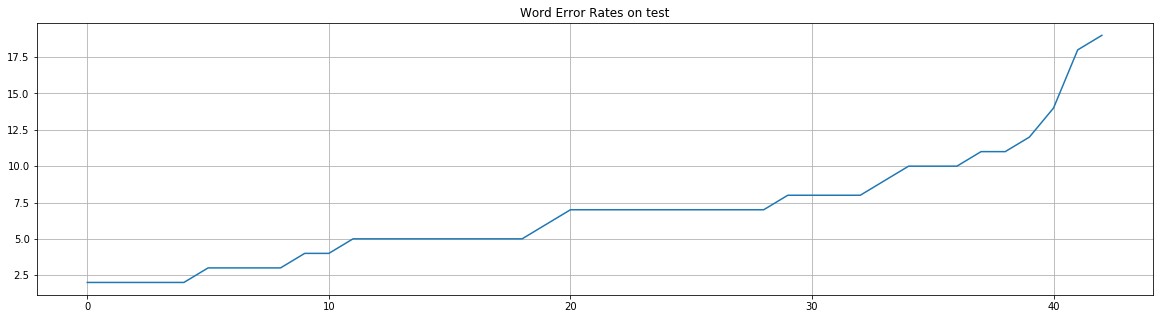

In [25]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(word_error_rates))],sorted(word_error_rates))
plt.title('Word Error Rates on test')
plt.grid()
plt.show()

Средняя ошибка на тесте получилась равна **6,86%** на чистых аудиозаписях без шумов. Добавим шумы на те же аудиозаписи и посмотрим, как изменится качество распознавания


In [48]:
noisy_test_audios=[]
noisy_test_texts=[]

def add_noise (filename, filename_dest):
    noise=AudioSegment.from_file('noise.wav')
    texture=AudioSegment.from_file(filename)
    print(noise)
    mixture=texture.overlay(noise)
    mixture.export(filename_dest,format='wav')
    
add_noise('p225_001.wav', 'noised.wav')

In [36]:
IPython.display.Audio('p225_001.wav')

In [37]:
IPython.display.Audio('noised.wav')

In [45]:
print('recognised: {}'.format(recognize('p225_001.wav')))
print('recognised noisy: {}'.format(recognize('noised.wav')))
print('original: {}'.format(open(text_adress[0][0],'r').read()))

INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
recognised: please colol stella
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
recognised noisy: ee
original: please call stella


Похоже, что модель ничего не знает про шумы и ее надо дорабатывать. Но, возможно, так вышло случайно и на других данных все будет ок? Для этого рассмотрим выборку зашумленных записей и посчитаем wer на них 

In [49]:
recognized_noisy_text=[]
word_error_rates=[]
# первые 5 аудиозаписей первых 5 людей
for i in tqdm(range(5)):
    try:
        for j in range(5):
            j += 5
            i += 5
            add_noise(audio_adress[i][j],'noisy.wav')
            tmp=recognize('noisy.wav')
            recognized_text.append(tmp)
            print(tmp)
            print('original:')
            o=open(text_adress[j][i],'r').read().lower()
            original=re.sub(r'[^\w\s]','',o)
            print(original)
            if len(original)==0:
                continue
            wer=word_error_rate(tmp,original)
            word_error_rates.append(wer)
            print('current wer: {}%'.format(wer))
            print('\n========================================================\n')
    except IndexError:
        print('no such record')
        continue


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


 20%|██        | 1/5 [00:09<00:38,  9.51s/it]

ere i  s o yu o so    s
original:
the rainbow is a division of white light into many beautiful colors 

current wer: 52%


no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e is some xec o   a s os om i 
original:
these take the shape of a long round arch with its path high above and its two ends apparently beyond the horizon 

current wer: 93%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e    os    e
original:
throughout the centuries people have explained the rainbow in various ways 

current wer: 66%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e   e   ros   s  in if as os  s e an so se e  
original:
others have tried to explain the phenomenon physically 

current wer: 42%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e ri i o s  o so e
original:
if the red of the second bow falls upon the green of the first the result is to g

 40%|████      | 2/5 [00:54<01:21, 27.09s/it]

e   wn you  
original:
i am not interested in the money it is the principle

current wer: 45%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e e e se in o thin s re ers n h o e h e the ac as f reson a for mere
original:
there is  according to legend a boiling pot of gold at one end 

current wer: 48%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919


 60%|██████    | 3/5 [01:12<00:48, 24.18s/it]

e  s  s    so
original:
some have accepted it as a miracle without physical explanation 

current wer: 53%


no such record
INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e   e sr os e h s s  e or es e e e
original:
people look but no one ever finds it 

current wer: 26%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e i e o mese re     
original:
to the hebrews it was a token that there would be no more universal floods 

current wer: 60%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e i  ten se os s  ran e  s s o  i   e srins i  e
original:
since then physicists have found that it is not reflection but refraction by the raindrops which causes the rainbows 

current wer: 85%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e    i o so so    oe  o  
original:
we are a service industry

current wer: 21%


INFO:tensorflow:Restoring parameters from /

 80%|████████  | 4/5 [02:02<00:30, 30.62s/it]

e    s som ese s se se s an s sin t some s o s  i s 
original:
on our numbers the price is in line with the asset value

current wer: 40%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e  siting hog es s e i so esicses e an o hing os
original:
throughout the centuries people have explained the rainbow in various ways 

current wer: 56%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e  es e e motse s i s s s s s s s s 
original:
the greeks used to imagine that it was a sign from the gods to foretell war or heavy rain 

current wer: 66%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e  se o  soe e e sos s s s s e i o e s e a e s i o se i s e
original:
many complicated ideas about the rainbow have been formed 

current wer: 47%


INFO:tensorflow:Restoring parameters from /workspace/code/code/model.ckpt-205919
e 
original:
but we will have to wait

current wer: 23%


INFO:tensorflow:

100%|██████████| 5/5 [02:54<00:00, 34.87s/it]

e i  muses  e  n e
original:
it is on the internet

current wer: 17%




In [50]:
print('mean wer: {}%'.format(np.array(word_error_rates).mean()))

mean wer: 55.55555555555556%


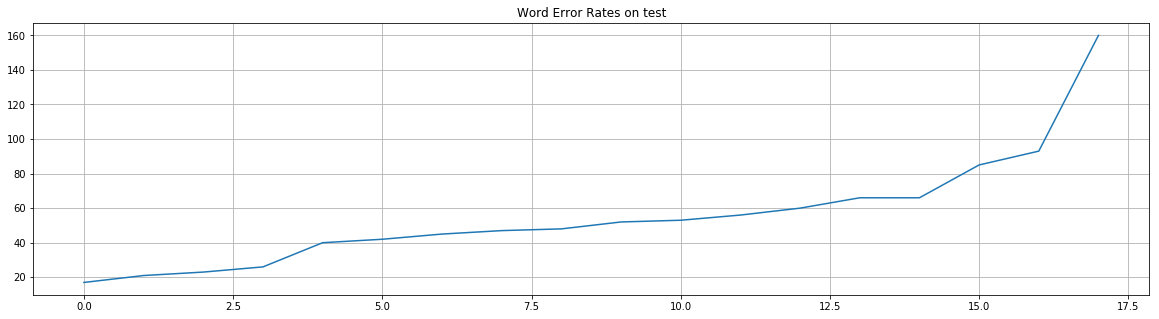

In [51]:
plt.figure(figsize=(20,5))
plt.plot([i for i in range(len(word_error_rates))],sorted(word_error_rates))
plt.title('Word Error Rates on test')
plt.grid()
plt.show()

При наличии шума на заднем плане ошибка увеличивается почти что в 9 раз. То же самое происходит с пением

Поэтому что стоит попробовать в первую очередь:
    1. Добавить в датасет зашумленные аудиозаписи
    2. Добавить в датасет аудиозаписи с междометиями и паузами как в реальной речи